# Сегментации клиентов с помощью RFM анализа


## Постановка задачи

Проведите RFM анализ датасета. В каждом подсегменте поделите пользователей на 4 класса.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('ht_data.csv', parse_dates=['InvoiceDate'])
print(f'Размерность данных - {df.shape}')
df.head()

Размерность данных - (332730, 4)


,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [3]:
# Приведем названия колонок к нижнему регистру
col_names = [(re.sub(r'([A-Z])', r' \1', i)).strip().replace(' ', '_').lower() for i in df.columns]
df.rename(columns={i: j for i, j in zip(df.columns, col_names)}, inplace=True)
df.head()

,invoice_no,customer_code,invoice_date,amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
# Посмотрим на типы данных в датафрейме
df.dtypes

invoice_no               object
customer_code            object
invoice_date     datetime64[ns]
amount                  float64
dtype: object

In [5]:
# Приведем типы данных к строковым
df['customer_code'] = df['customer_code'].astype('str')
df['invoice_no'] = df['invoice_no'].astype('str')

In [6]:
# Посмотрим на описательную статистику
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
amount,332730.0,1239.03,1747.362,-8925.0,350.0,720.445,1491.508,131874.0


In [7]:
# Посмотрим на значения amount меньше нуля
df[df.amount < 0][:5]

,invoice_no,customer_code,invoice_date,amount
5196,D0581810010128,13166218,2020-09-01,-3.80
12807,D0211810020467,13163058,2020-09-02,-80.00
12926,D0231810020120,18099094,2020-09-02,-639.77
13726,D0311810020291,19000021,2020-09-02,-1.00
28017,D0621810030773,13134281,2020-09-03,-140.00


Наличие отрицательных значений предполагает, что по некоторым операциям могли быть возвраты.

In [8]:
# Посмотрим на описательную статистику по категориальным переменным
df.describe(include=['O']).T

,count,unique,top,freq
invoice_no,332730,332730,C0011810010001,1
customer_code,332730,123733,19057820,204


In [9]:
# Посмотрим на минимальную и максимальную даты в наших данных
min_date = df.invoice_date.min()
max_date = df.invoice_date.max()
print(f'Min Invoice Date: {min_date} \nMax Invoice Date: {max_date}')

Min Invoice Date: 2020-09-01 00:00:00 
Max Invoice Date: 2020-09-30 00:00:00


Рассчитаем **RFM** метрики для каждого клиента, для этого сгруппируем данные по `customer_code`, определим самую позднюю дату покупки с момента последней записи в наших данных (`2020-09-30`), посчитаем общее количество покупок за весь анализируемый период, и суммируем суммы покупок для каждого клиента.

In [10]:
# Посчитаем RFM метрики
rfm_df = df.groupby(['customer_code'], as_index=False) \
        .agg(recency=('invoice_date', lambda x : (max_date - x.max()).days),
             frequency=('invoice_no', 'count'), 
             monetary_value=('amount', 'sum'))

rfm_df.head()

,customer_code,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88


In [11]:
# Посмотрим на описательную статистику по полученным метрикам
rfm_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
recency,123733.0,9.80,8.56,0.0,2.0,8.00,16.00,29.00
frequency,123733.0,2.69,2.89,1.0,1.0,2.00,3.00,204.00
monetary_value,123733.0,3331.87,6131.42,-80.0,765.0,1834.48,4008.84,711487.71


Воспользуемся функцией `quantile` для вычисления размера каждого интервала, чтобы гарантировать, что распределение данных в интервалах одинаково. Другими словами, все интервалы будут иметь (примерно) одинаковое количество наблюдений.

In [12]:
# Зададим границы классов
quantiles = rfm_df.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


Оценим «Давность» для клиента, который был активен совсем недавно выше чем клиент, который был активен очень давно. «Частоту» и «Денежную ценность» будем оценивать выше с увеличением этим переменных, потому что мы хотим, чтобы клиент тратил больше денег и посещал чаще. Таким образом:

- Лучшая оценка `Recency` = 1 (покупка была совсем недавно)
- Лучшая оценка `Frequency` = 1 (самая большая частота покупок)
- Лучшая оценка `Monetary`= 1 (самая большая сумма покупки)

In [13]:
# Определим функцию для сегментации по давности покупки
def recency_class(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

# Определим функцию для сегментации по частоте покупки и общей сумме покупок
def frequency_monetary_class(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [14]:
# Определим категории для RFM метрик
rfm_df['R'] = rfm_df['recency'].apply(recency_class, args=('recency', quantiles))
rfm_df['F'] = rfm_df['frequency'].apply(frequency_monetary_class, args=('frequency', quantiles))
rfm_df['M'] = rfm_df['monetary_value'].apply(frequency_monetary_class, args=('monetary_value', quantiles))

# Добавим в rfm_df столбец с RFM сегментом
rfm_df['rfm_segment'] = rfm_df.R.astype('str') + rfm_df.F.astype('str') + rfm_df.M.astype('str')
rfm_df.head()

,customer_code,recency,frequency,monetary_value,R,F,M,rfm_segment
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


In [15]:
# Выведем для каждого кластера средние значения метрик R, F, M
rfm_segment_means = rfm_df.groupby('rfm_segment') \
    .agg({'recency': 'mean',
          'frequency': 'mean',
          'monetary_value': ['mean', 'count']}) \
    .round(2)

rfm_segment_means.columns = ['recency_mean','frequency_mean','monetary_mean', 'size']
rfm_segment_means.reset_index(inplace=True)
rfm_segment_means.head()

,rfm_segment,recency_mean,frequency_mean,monetary_mean,size
0,111,0.54,8.31,11244.45,9705
1,112,0.61,5.57,2950.03,3602
2,113,0.65,4.73,1410.60,1066
3,114,0.68,4.17,619.62,60
4,121,0.63,3.00,7413.67,1527


In [16]:
# Посмотрим в каком RFM-сегменте самое большое кол-во пользователей
rfm_segment_means[rfm_segment_means['size'] == rfm_segment_means['size'].max()]

,rfm_segment,recency_mean,frequency_mean,monetary_mean,size
63,444,23.03,1.0,390.59,10624


In [17]:
# Посмотрим в каком RFM-сегменте меньше всего пользователей
rfm_segment_means[rfm_segment_means['size'] == rfm_segment_means['size'].min()]

,rfm_segment,recency_mean,frequency_mean,monetary_mean,size
51,414,19.0,4.0,730.44,2


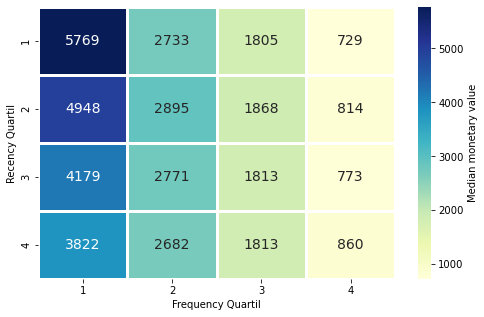

In [18]:
# Визуализируем медианное значение monetary_value в зависимости от принадлежности к R и F классам
plt.figure(figsize=(8, 5))
rfm_table = rfm_df.pivot_table(index='R', columns='F', values='monetary_value', aggfunc='median')
ax = sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt='.0f', linewidths=3,
                 annot_kws={'size': 14}, cbar_kws={'label': 'Median monetary value'})

ax.set(xlabel='Frequency Quartil', ylabel='Recency Quartil');